In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import inspect
import logging
import copy
import importlib
import math
from pathlib import Path
from datetime import datetime
from textwrap import wrap

In [2]:
cf = importlib.import_module("calc_funcs_v1l")
try:
    plot_funcs_ver = "pf" + Path(__file__).stem[-3:]
except:
    plot_funcs_ver = "pfv00"
plt.rcParams['text.usetex'] = True
da_dims_valid = ("latitude", "longitude")
da_names_cyclic = ["hour_max", "hour_min"]
da_names_viridis_with_vmin_0 = (["range", "lse", "ssgo"] + 
                                cf.params_glass_mean + cf.params_wsd)
vars_viridis_with_vmin_0 = ["ws10", "ws100", "tcclw", "tcwv"]
vars_viridis = ["mslp", "t2", "vipile", "vike"]
figwidth_individual = 10
title_width = 60

In [3]:
def get_plot_metadata(time_exec_1up, func_1up, args_1up, args_1up_values):
    
    time_str = time_exec_1up.strftime("%Y-%m-%d-%H-%M-%S")
    
    args_1up_list = []
        
    for arg in args_1up:
        arg_value = args_1up_values[arg]
        arg_value_type = str(type(arg_value))
        
        if ((arg_value_type == "<class 'xarray.core.dataset.Dataset'>") | 
            (arg_value_type == "<class 'xarray.core.dataarray.DataArray'>")):
            arg_str = arg
        else:
            arg_str = str(arg_value)
            
        if arg_value_type == "<class 'str'>":
            arg_str = arg_str.replace(arg_value, f"'{arg_value}'")
              
        if arg_value_type == "<class 'function'>":
            arg_str = arg_str.split(" ")[1]
                
        args_1up_list.append(arg_str)
            
    args_1up_str = ", ".join(arg_input for arg_input in args_1up_list)
    
    return {"History": f"{func_1up}({args_1up_str})_{time_str}"}

In [4]:
def get_common_cbar_limits(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None, extents=None
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
        
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period1).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period1}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period1 = (xr.open_dataset(path_period1, engine = "netcdf4")
                  .sel(longitude=slice(extents[0], extents[1]), 
                       latitude=slice(extents[3], extents[2]))
                 )
    
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period2).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period2}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period2 = (xr.open_dataset(path_period2, engine = "netcdf4")
                  .sel(longitude=slice(extents[0], extents[1]), 
                       latitude=slice(extents[3], extents[2]))
                 )
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            da_u_period1 = ds_period1[var_or_dvar.replace("wv", "u")]
            da_v_period1 = ds_period1[var_or_dvar.replace("wv", "v")]
            da_u_period2 = ds_period2[var_or_dvar.replace("wv", "u")]
            da_v_period2 = ds_period2[var_or_dvar.replace("wv", "v")]
            da_mag_period1 = cf.get_magnitude(da_u_period1, da_v_period1)
            da_mag_period2 = cf.get_magnitude(da_u_period2, da_v_period2)
            vmin = 0
            vmax = float(max(da_mag_period1.max(), da_mag_period2.max()))
        else:
            da_period1 = ds_period1[var_or_dvar].sel(hour=arg_extra)
            da_period2 = ds_period2[var_or_dvar].sel(hour=arg_extra)
            main_param_period2 = (da_period2.attrs["abbreviation"]
                                  .split("(")[-1]
                                  .split(")")[0]
                                  .split("^")[0]
                                  .split("$")[0]
                                  .lower())
            if da_period2.name in da_names_cyclic:
                vmin = None
                vmax = None
            elif da_period2.name in da_names_viridis_with_vmin_0:
                vmin = 0
                vmax = float(max(da_period1.max(), da_period2.max()))
            elif main_param_period2 in vars_viridis_with_vmin_0:
                vmin = 0
                vmax = float(max(da_period1.max(), da_period2.max()))
            elif main_param_period2 in vars_viridis:
                vmin = float(min(da_period1.min(), da_period2.min()))
                vmax = float(max(da_period1.max(), da_period2.max()))
            else:
                min_of_mins = float(min(da_period1.min(), da_period2.min()))
                max_of_maxs = float(max(da_period1.max(), da_period2.max()))
                vmin = min(-abs(min_of_mins), -abs(max_of_maxs))
                vmax = -vmin
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        da_u_period1 = ds_period1[arg_extra + "_u"]
        da_v_period1 = ds_period1[arg_extra + "_v"]
        da_u_period2 = ds_period2[arg_extra + "_u"]
        da_v_period2 = ds_period2[arg_extra + "_v"]
        da_mag_period1 = cf.get_magnitude(da_u_period1, da_v_period1)
        da_mag_period2 = cf.get_magnitude(da_u_period2, da_v_period2)
        vmin = 0
        vmax = float(max(da_mag_period1.max(), da_mag_period2.max()))
    else:
        da_period1 = ds_period1[arg_extra]
        da_period2 = ds_period2[arg_extra]
        main_param_period2 = (da_period2.attrs["abbreviation"]
                              .split("(")[-1]
                              .split(")")[0]
                              .split("^")[0]
                              .split("$")[0]
                              .lower())
        if da_period2.name in da_names_cyclic:
            vmin = None
            vmax = None
        elif da_period2.name in da_names_viridis_with_vmin_0:
            vmin = 0
            vmax = float(max(da_period1.max(), da_period2.max()))
        elif main_param_period2 in vars_viridis_with_vmin_0:
            vmin = 0
            vmax = float(max(da_period1.max(), da_period2.max()))
        elif main_param_period2 in vars_viridis:
            vmin = float(min(da_period1.min(), da_period2.min()))
            vmax = float(max(da_period1.max(), da_period2.max()))
        else:
            min_of_mins = float(min(da_period1.min(), da_period2.min()))
            max_of_maxs = float(max(da_period1.max(), da_period2.max()))
            vmin = min(-abs(min_of_mins), -abs(max_of_maxs))
            vmax = -vmin
    
    cf.remove_handlers_if_directly_executed(func_1up)
    
    return vmin, vmax

In [5]:
def create_pcolormesh(da, extents=None, vmin=None, vmax=None, ax=None):
    
    # Lowest level of plotting; notice that this function will work even for
    # the MDPs of variable dependencies which are not used in the final analysis
    # (eg. vidmf, etc.) as opposed to the higher level plotting functions.
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_individual
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    main_param = (da.attrs["abbreviation"]
                  .split("(")[-1]
                  .split(")")[0]
                  .split("^")[0]
                  .split("$")[0]
                  .lower())
    
    levels = None
    
    if da.attrs["full_name"].split(" ")[1] == "Rolling":
        cmap = cmocean.cm.balance_r
        if (vmin == None) & (vmax == None):
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            min_of_da = float(da.min())
            max_of_da = float(da.max())
            vmin = min(-abs(min_of_da), -abs(max_of_da))
            vmax = -vmin
    elif da.attrs["full_name"].split(" ")[0] == "Difference":
        if da.name in da_names_cyclic:
            cmap = "twilight_shifted_r"
            levels = np.arange(-12, 13)
        else:
            cmap = cmocean.cm.balance_r
            if (vmin == None) & (vmax == None):
                da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                                   latitude=slice(extents[3], extents[2]))
                min_of_da = float(da.min())
                max_of_da = float(da.max())
                vmin = min(-abs(min_of_da), -abs(max_of_da))
                vmax = -vmin
    else:
        if da.name in da_names_cyclic:
            cmap = cmocean.cm.phase
            levels = np.arange(0, 25)
        elif da.name in da_names_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else da_subset.min()
            vmax = vmax if vmax else da_subset.max()
        else:
            cmap = cmocean.cm.balance_r
            if (vmin == None) & (vmax == None):
                da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                                   latitude=slice(extents[3], extents[2]))
                min_of_da = float(da.min())
                max_of_da = float(da.max())
                vmin = min(-abs(min_of_da), -abs(max_of_da))
                vmax = -vmin
    
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    
    if da.attrs["full_name"].split(" ")[1] == "Rolling":
        ax_label = "{}".format(da.attrs["abbreviation"])
    else:
        ax_label = "{} [{}]".format(da.attrs["abbreviation"], da.attrs["units"])
        
    da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                       vmin = vmin, vmax = vmax, levels = levels, 
                       cbar_kwargs = {"label": ax_label}
                      )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    grid.top_labels = False
    grid.right_labels = False
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [6]:
def create_quiver(da_u, da_v, extents=None, vmin=None, vmax=None, ax=None):
    
    assert ((str(type(da_u)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_u.dims == da_dims_valid)), \
        f"da_u must be an xarray.DataArray with da_u.dims == {da_dims_valid}"
    
    assert ((str(type(da_v)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_v.dims == da_dims_valid)), \
        f"da_v must be an xarray.DataArray with da_v.dims == {da_dims_valid}"
    
    attrs_u = copy.deepcopy(da_u.attrs)
    attrs_u["abbreviation"] = attrs_u["abbreviation"].replace("_u", "")
    attrs_u["full_name"] = (attrs_u["full_name"]
                            .replace("Zonal Component of ", ""))
    
    attrs_v = copy.deepcopy(da_v.attrs)
    attrs_v["full_name"] = (attrs_v["full_name"]
                            .replace("Meridional Component of ", ""))
    
    assert attrs_u["full_name"] == attrs_v["full_name"], \
        ("da_u and da_v must be the zonal and meridional components " +
         "of the same variable")
    
    vector_test = (attrs_u["abbreviation"]
                   .split("(")[-1]
                   .split(")")[0]
                   .split("^")[0]
                   .split("$")[0]
                   .replace("U", "WV")
                   .lower())
    
    assert vector_test in cf.params_vector, \
        "da_u and da_v must be the components of a vector parameter"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da_u.longitude.min())
        extents.append(da_u.longitude.max())
        extents.append(da_u.latitude.min())
        extents.append(da_u.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    else:
        vmin = 0
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_individual
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    da_mag = xr.DataArray(cf.get_magnitude(da_u, da_v), name = "mag")
    da_u_unit = xr.DataArray(da_u / da_mag, name = "u_unit")
    da_v_unit = xr.DataArray(da_v / da_mag, name = "v_unit")
    ds = xr.merge([da_mag, da_u_unit, da_v_unit])
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    ds.plot.quiver(x = "longitude", y = "latitude", ax = ax, 
                   u = "u_unit", v = "v_unit", hue = "mag", 
                   vmin = vmin, vmax = vmax, 
                   cmap = cmocean.cm.speed, transform = ccrs.PlateCarree(),
                   cbar_kwargs={"label": "{} [{}]"
                                .format(attrs_u["abbreviation"], 
                                        attrs_u["units"])
                               }
                  )
    ax.set_title(attrs_u["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    grid.top_labels = False
    grid.right_labels = False
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [7]:
def create_individual_calc_plot(
    calc_func, region, period_start, period_end, months_subset, arg_extra, 
    glass_source_pref=None, var_or_dvar=None, extents=None, 
    vmin=None, vmax=None, ax=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period_start, 
                  period_end=period_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_individual
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_calc = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period_start, 
        period_end=period_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    if Path(path_calc).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_calc}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_calc = xr.open_dataset(path_calc, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            create_quiver(da_u=ds_calc[var_or_dvar.replace("wv", "u")], 
                          da_v=ds_calc[var_or_dvar.replace("wv", "v")], 
                          extents=extents, vmin=vmin, vmax=vmax, ax=ax)
        else:
            create_pcolormesh(ds_calc[var_or_dvar].sel(hour=arg_extra), 
                              extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        create_quiver(da_u=ds_calc[arg_extra + "_u"], 
                      da_v=ds_calc[arg_extra + "_v"], 
                      extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        create_pcolormesh(ds_calc[arg_extra], extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    ax_title = ax.get_title()
    ax.set_title("\n".join(wrap(f"{ax_title} ({period_start} to {period_end}; " + 
                                f"{months_subset_str} months)", title_width)))
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_calc
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [8]:
def create_individual_diff_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None, 
    extents=None, vmin=None, vmax=None, ax=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_individual
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period1).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period1}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
    
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period2).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period2}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset, glass_source_pref=glass_source_pref,
                  var_or_dvar=var_or_dvar)
    
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
    
    path_diff = cf.get_path_for_calc_diff(
        calc_func_name=calc_func_name, region=region, 
        period1_start=period1_start, period1_end=period1_end, 
        period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, glass_source_pref=glass_source_pref,
        var_or_dvar=var_or_dvar
    )
    
    if Path(path_diff).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_diff}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_diff(calc_func=calc_func, region=region, 
                     period1_start=period1_start, period1_end=period1_end, 
                     period2_start=period2_start, period2_end=period2_end, 
                     months_subset=months_subset, glass_source_pref=glass_source_pref,
                     var_or_dvar=var_or_dvar)
    
    ds_diff = xr.open_dataset(path_diff, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.params_vector:
            create_quiver(da_u=ds_diff[var_or_dvar.replace("wv", "u")], 
                          da_v=ds_diff[var_or_dvar.replace("wv", "v")], 
                          extents=extents, vmin=vmin, vmax=vmax, ax=ax)
        else:
            create_pcolormesh(ds_diff[var_or_dvar].sel(hour=arg_extra), 
                              extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.params_vector) & (arg_extra in ["max", "min", "mean"]):
        create_quiver(da_u=ds_diff[arg_extra + "_u"], 
                      da_v=ds_diff[arg_extra + "_v"], 
                      extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        create_pcolormesh(ds_diff[arg_extra], extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
    
    months_subset_str = cf.get_months_subset_str(months_subset=months_subset)
    ax_title = ax.get_title()
    ax.set_title("\n".join(wrap(f"{ax_title} ({period2_start} to {period2_end} " +
                                f"minus {period1_start} to {period1_end}; " + 
                                f"{months_subset_str} months)", title_width)))
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [9]:
def create_individual_comp_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, glass_source_pref=None, var_or_dvar=None, extents=None, 
    vmin_periods=None, vmax_periods=None, vmin_diff=None, vmax_diff=None, 
    ax_period1=None, ax_period2=None, ax_diff=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    calc_func_name = calc_func.__name__
    
    cf.check_args_for_none(calc_func_name, args_cur, args_cur_values)
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                  period_end=period1_end, months_subset=months_subset, 
                  glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset)
    
    if calc_func_name == "calc_glass_mean_clim":
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert arg_extra in cf.params_stat, \
            (f"arg_extra must be one of: {cf.params_stat} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin_periods:
        assert isinstance(vmin_periods, float) | isinstance(vmin_periods, int), \
            "vmin_periods must have data type float or int"
    
    if vmax_periods:
        assert isinstance(vmax_periods, float) | isinstance(vmax_periods, int), \
            "vmax_periods must have data type float or int"
    
    if (vmin_periods is not None) & (vmax_periods is not None):
        assert vmax_periods >= vmin_periods, \
            "vmax_periods must be equal to or greater than vmin_periods"
    
    if (vmin_periods == None) & (vmax_periods == None):
        vmin_periods, vmax_periods = get_common_cbar_limits(
            calc_func=calc_func, region=region, period1_start=period1_start, 
            period1_end=period1_end, period2_start=period2_start, 
            period2_end=period2_end, months_subset=months_subset, 
            arg_extra=arg_extra, glass_source_pref=glass_source_pref,
            var_or_dvar=var_or_dvar, extents=extents
        )
    
    if vmin_diff:
        assert isinstance(vmin_diff, float) | isinstance(vmin_diff, int), \
            "vmin_diff must have data type float or int"
    
    if vmax_diff:
        assert isinstance(vmax_diff, float) | isinstance(vmax_diff, int), \
            "vmax_diff must have data type float or int"
    
    ax_diff_input = ax_diff
    axes_input = [ax_period1, ax_period2, ax_diff]
    
    assert (all(ax_input == None for ax_input in axes_input) | 
            all(ax_input != None for ax_input in axes_input)), \
        "ax_period1, ax_period2, ax_diff must be either all None or all not None"
    
    if ax_diff:
        assert str(type(ax_period1)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period1 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_period2)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period2 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_diff)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_diff must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 3
        figwidth = figwidth_individual * 2
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                                 subplot_kw = {"projection": ccrs.PlateCarree()}
                                )
        ax_period1 = axes[0]
        ax_period2 = axes[1]
        ax_diff = axes[2]
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, extents=extents, 
        vmin=vmin_periods, vmax=vmax_periods, ax=ax_period1, output=False
    )
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, extents=extents, 
        vmin=vmin_periods, vmax=vmax_periods, ax=ax_period2, output=False
    )
    create_individual_diff_plot(
        calc_func=calc_func, region=region, period1_start=period1_start, 
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end, 
        months_subset=months_subset, arg_extra=arg_extra, 
        glass_source_pref=glass_source_pref, var_or_dvar=var_or_dvar, extents=extents, 
        vmin=vmin_diff, vmax=vmax_diff, ax=ax_diff, output=False
    )
    
    if ax_diff_input == None:
        fig.tight_layout()
        
        if output == True:
            path_diff = cf.get_path_for_calc_diff(
                calc_func_name=calc_func_name, region=region, 
                period1_start=period1_start, period1_end=period1_end, 
                period2_start=period2_start, period2_end=period2_end,
                months_subset=months_subset, glass_source_pref=glass_source_pref,
                var_or_dvar=var_or_dvar
            )
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                           .replace("diff", "comp")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [10]:
def create_orog_static_plot(param_orog, extents=None, vmin=None, vmax=None, 
                            ax=None, output=False):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    assert param_orog in cf.params_orog, \
        f"param_orog must be one of: {cf.params_orog}"
    
    extents_default = [-180, 180, -90, 90]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figrows = 1
        figcols = 1
        figwidth = figwidth_individual
        figheight = (figwidth * figrows/figcols * 
                     (extents[3]-extents[2])/(extents[1]-extents[0])
                    )
        fig, ax = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_orog = cf.get_path_for_era5_orog()
    if Path(path_orog).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_orog}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_era5_orog()
    
    da_orog = xr.open_dataset(path_orog, engine = "netcdf4")[param_orog]
    
    create_pcolormesh(da_orog, extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_orog
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{param_orog}.png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
        
        cf.remove_handlers_if_directly_executed(func_1up)

In [11]:
def create_glass_rolling_plot(region, year_start, year_end, window_size, param_glass_mean, 
                              glass_source_pref, extents=None, vmin=None, vmax=None, 
                              output=False):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                       args_cur, args_cur_values)
    
    cf.check_args_for_none(func_cur, args_cur, args_cur_values)
    cf.check_args(region=region, year_start=year_start, year_end=year_end, 
                  window_size=window_size, glass_source_pref=glass_source_pref)
    
    assert param_glass_mean in cf.params_glass_mean, \
        f"param_glass_mean must be one of: {cf.params_glass_mean}"
    
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    if (vmin is not None) & (vmax is not None):
        assert vmax >= vmin, \
            "vmax must be equal to or greater than vmin"
        
    assert output in [True, False], \
        "output must be one of: [True, False]"  
    
    path_roll = cf.get_path_for_calc_glass_rolling(
        region=region, year_start=year_start, year_end=year_end, 
        window_size=window_size, glass_source_pref=glass_source_pref)
    
    if Path(path_roll).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_roll}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_glass_rolling_avg_of_annual_diff(
            region=region, year_start=year_start, year_end=year_end, 
            window_size=window_size, glass_source_pref=glass_source_pref)
    da_roll = xr.open_dataset(path_roll, engine = "netcdf4")[param_glass_mean]
    
    if cf.priority == "speed":
        da_roll = da_roll.persist()
    
    if (vmin == None) & (vmax == None):
        min_of_da_roll = float(da_roll.min())
        max_of_da_roll = float(da_roll.max())
        vmin = min(-abs(min_of_da_roll), -abs(max_of_da_roll))
        vmax = -vmin    
    
    figcols = 4
    figrows = math.ceil(len(da_roll.year) / figcols)
    figwidth = figwidth_individual * 2
    figheight = (figwidth * figrows/figcols * 
                 (extents[3]-extents[2])/(extents[1]-extents[0])
                )
    fig, axes = plt.subplots(figrows, figcols, figsize=(figwidth, figheight), 
                             subplot_kw = {"projection": ccrs.PlateCarree()}
                            )
    
    for idx, year in enumerate(da_roll.year.data):
        row = math.floor(idx / figcols)
        col = idx % figcols
        da_roll_year = da_roll.sel(year=year)
        create_pcolormesh(da=da_roll_year, extents=extents, 
                          vmin=vmin, vmax=vmax, ax=axes[row, col])
        ax_title = (("{}-Year Rolling Average of Annual Difference in {} " +
                     "(centred upon {})")
                    .format(window_size, param_glass_mean.upper(), year))
        axes[row, col].set_title("\n".join(wrap(ax_title, title_width)))
    
    fig.tight_layout()
        
    if output == True:
        path_output = (path_roll
                       .replace("data_processed", "data_final")
                       .replace(".nc", f"_{param_glass_mean}.png")
                      )
        path_output_dir = "/".join(path_output.split("/")[:-1])
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)
        path_output = path_output.replace(
            path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
        if Path(path_output).exists():
            msg_exist = ("WARNING: plot file already exists (and was " +
                         f"not overwritten): {path_output}")
            logging.warning(msg_exist)
            print(msg_exist)
        else:
            plt.savefig(path_output, metadata=get_plot_metadata(
                time_exec, func_cur, args_cur, args_cur_values)
                       )
            msg_create = f"CREATED: plot file: {path_output}"
            logging.info(msg_create)
            print(msg_create)
                
    plt.show()
        
    cf.remove_handlers_if_directly_executed(func_1up)

In [ ]:
test12 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/cfv00_calc_wa_1983_2019_5-year_glass-rolling-diff_pref-avhrr.nc")
test12

CREATED: log file for create_glass_rolling_plot: ../logs/create_glass_rolling_plot/create_glass_rolling_plot('wa', 1983, 2019, 5, 'mlai', 'avhrr', None, None, None, True)_2022-09-27-22-58-59_cfv1l.txt.
CREATED: file for use in calc_diff: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1981_Dec-1981_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_glass_rolling_avg_of_annual_diff: ../data_processed/glass_mean_clim/cfv1l_diff_wa_Jan-1981_Dec-1981_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
Opening: existing file for use in calc_diff: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1983_Dec-1983_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_glass_rolling_avg_of_annual_diff: ../data_processed/glass_mean_clim/cfv1l_diff

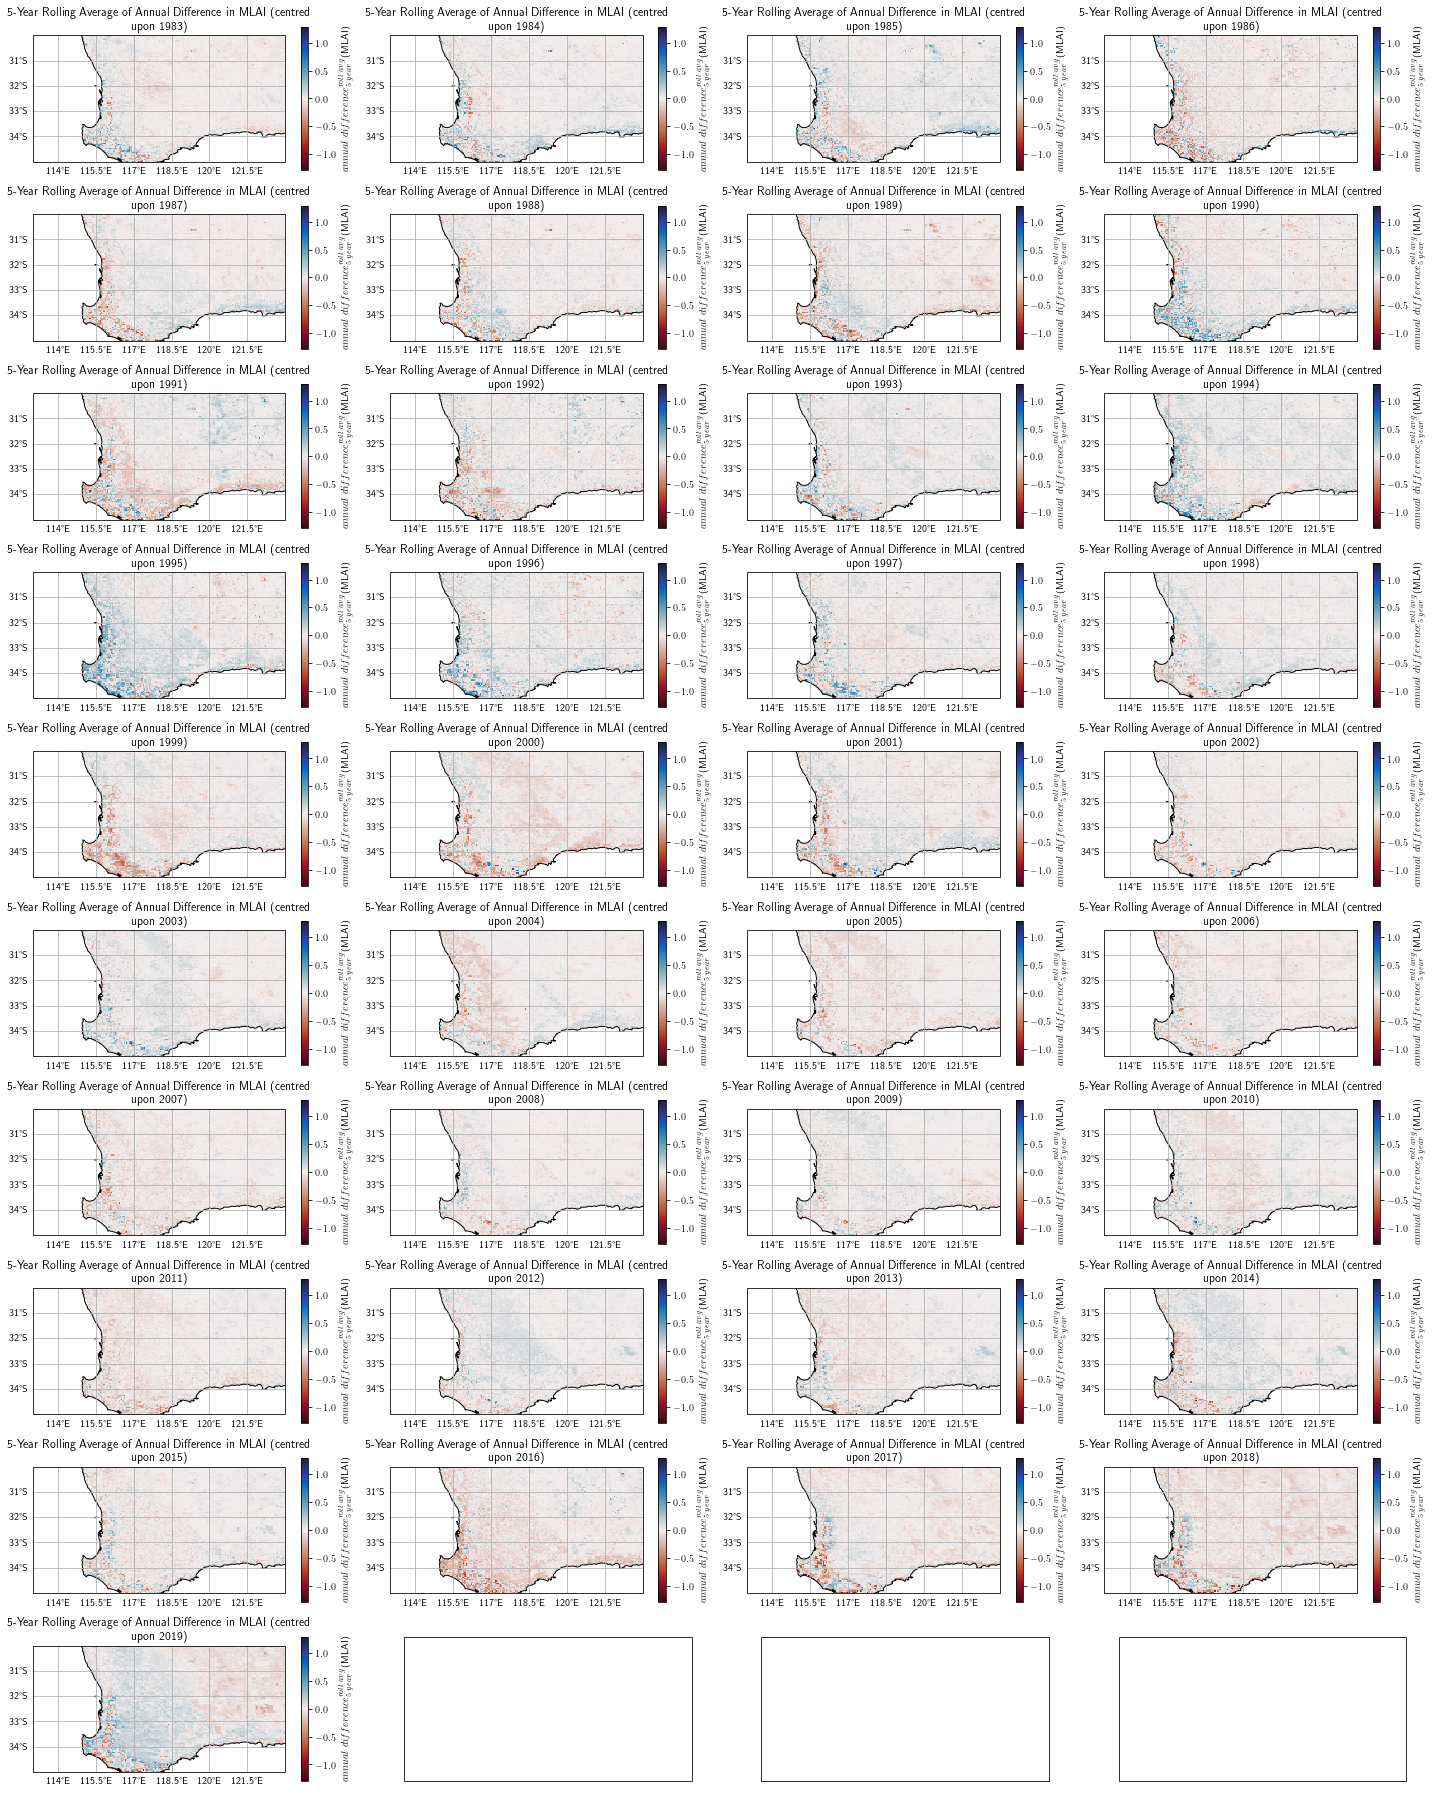

CPU times: user 11min 56s, sys: 4min 38s, total: 16min 34s
Wall time: 15min 11s


In [13]:
%%time
create_glass_rolling_plot("wa", 1983, 2019, 5, "mlai", glass_source_pref="avhrr", output=True)

CREATED: log file for create_glass_rolling_plot: ../logs/create_glass_rolling_plot/create_glass_rolling_plot('wa', 1983, 2019, 5, 'mfapar', 'avhrr', None, None, None, True)_2022-09-27-23-14-10_cfv1l.txt.
Opening: existing file for use in create_glass_rolling_plot: ../data_processed/glass_rolling_avg_of_annual_diff/cfv1l_calc_wa_1983_2019_5-year_glass-rolling-diff_pref-avhrr.nc
CREATED: plot file: ../data_final/glass_rolling_avg_of_annual_diff/pfv00_cfv1l_calc_wa_1983_2019_5-year_glass-rolling-diff_pref-avhrr_mfapar.png


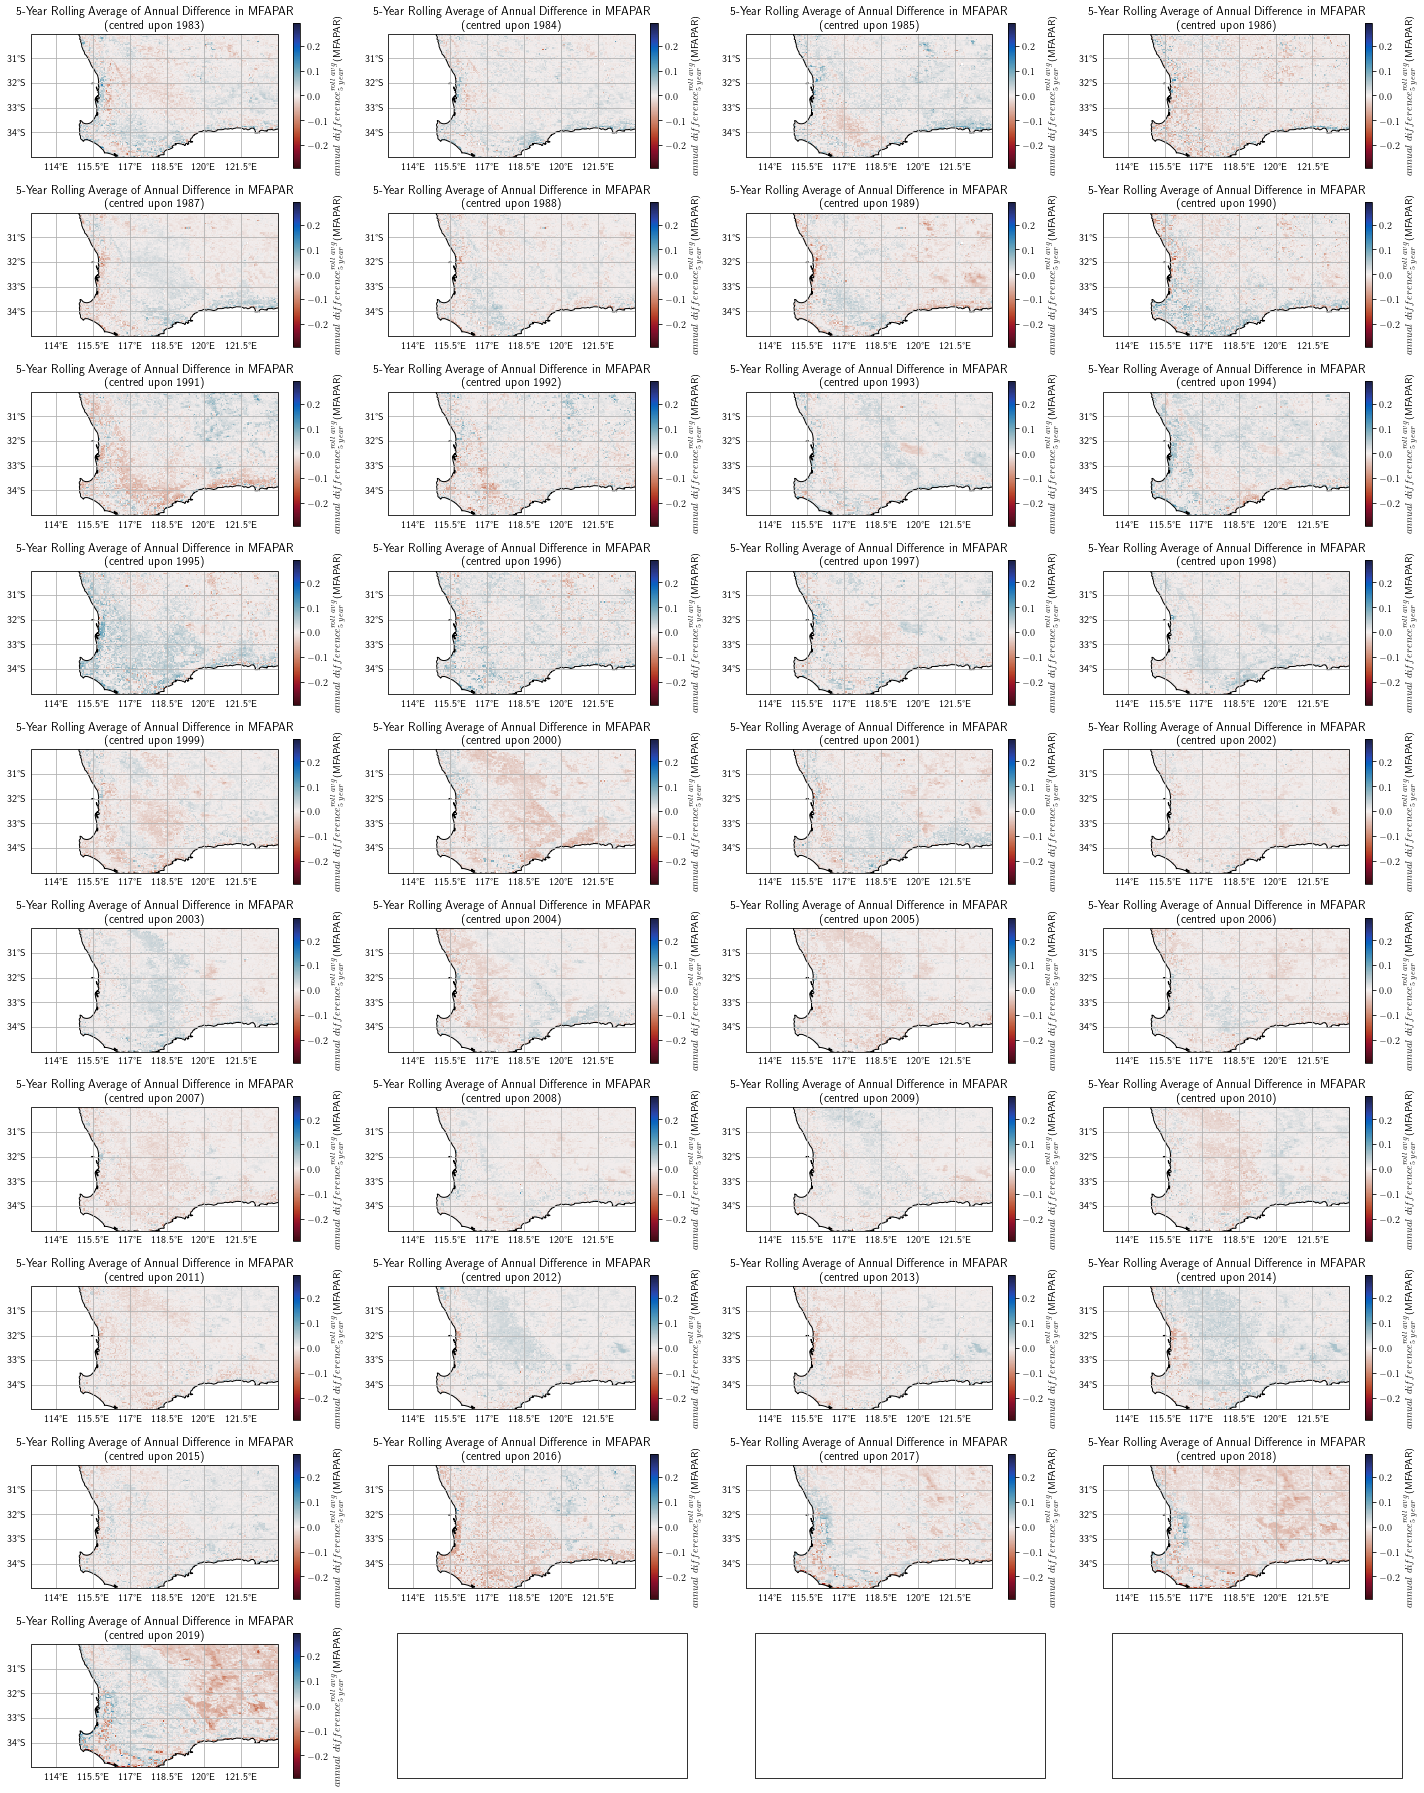

CPU times: user 8.5 s, sys: 4.44 s, total: 12.9 s
Wall time: 7.28 s


In [14]:
%%time
create_glass_rolling_plot("wa", 1983, 2019, 5, "mfapar", glass_source_pref="avhrr", output=True)

CREATED: log file for create_orog_static_plot: ../logs/create_orog_static_plot/create_orog_static_plot('lse', [113, 123, -35, -30], None, None, None, True)_2022-09-27-23-14-17_cfv1l.txt.
Opening: existing file for use in calc_era5_orog: ../data_raw/global_era5-slv_static/global_era5-slv_static_all.nc.
CREATED: file for use in create_orog_static_plot: ../data_processed/era5_orog/cfv1l_calc_global_era5-orog.nc.
CREATED: plot file: ../data_final/era5_orog/pfv00_cfv1l_calc_global_era5-orog_lse.png


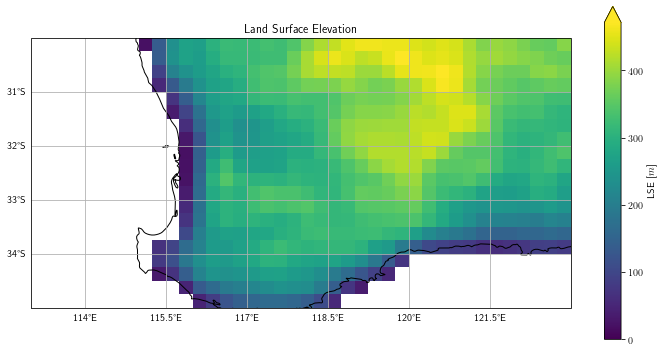

CPU times: user 1.18 s, sys: 432 ms, total: 1.61 s
Wall time: 1.09 s


In [15]:
%%time
create_orog_static_plot("lse", cf.regions["wa"]["extent"], output=True)

CREATED: log file for create_orog_static_plot: ../logs/create_orog_static_plot/create_orog_static_plot('ssgo', [113, 123, -35, -30], None, None, None, True)_2022-09-27-23-14-18_cfv1l.txt.
Opening: existing file for use in create_orog_static_plot: ../data_processed/era5_orog/cfv1l_calc_global_era5-orog.nc
CREATED: plot file: ../data_final/era5_orog/pfv00_cfv1l_calc_global_era5-orog_ssgo.png


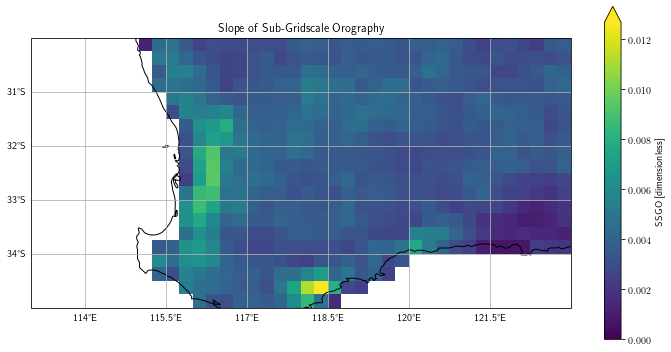

CPU times: user 1.07 s, sys: 472 ms, total: 1.54 s
Wall time: 939 ms


In [16]:
%%time
create_orog_static_plot("ssgo", cf.regions["wa"]["extent"], output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_glass_mean_clim, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mlai', 'avhrr', None, None, None, None, None, None, None, None, None, True)_2022-09-27-23-14-19_cfv1l.txt.
CREATED: file for use in get_common_cbar_limits: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc.
Opening: existing file for use in create_individual_calc_plot: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/glass_mean_clim/cfv1l_calc_wa_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/glass_mean_clim/cfv1l_calc_

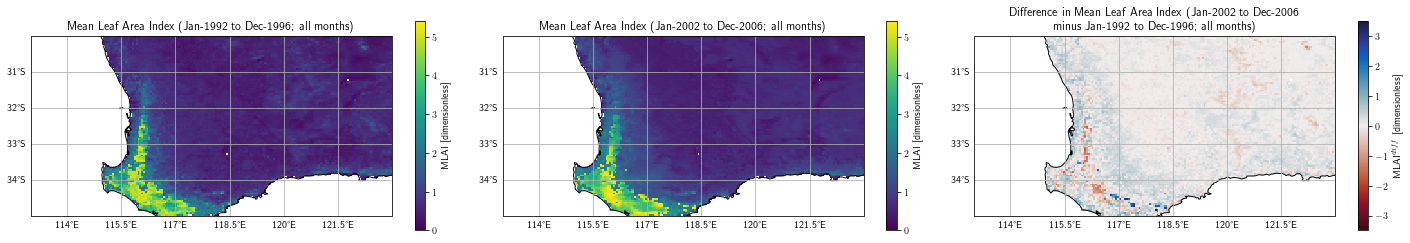

CPU times: user 2min 56s, sys: 59.9 s, total: 3min 56s
Wall time: 3min 35s


In [17]:
%%time
create_individual_comp_plot(cf.calc_glass_mean_clim, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mlai", glass_source_pref="avhrr", output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', None, 'nac', None, None, None, None, None, None, None, None, True)_2022-09-27-23-17-55_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_nac.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_nac_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_nac.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_nac_stats.nc.
Op

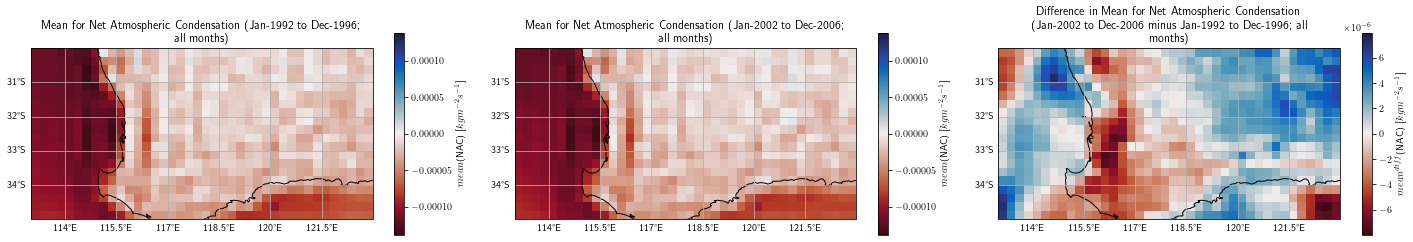

CPU times: user 4.11 s, sys: 622 ms, total: 4.73 s
Wall time: 3.93 s


In [18]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", var_or_dvar="nac", output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', None, 'tcclw', None, None, None, None, None, None, None, None, True)_2022-09-27-23-17-58_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_tcclw.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_tcclw_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_tcclw.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_tcclw_st

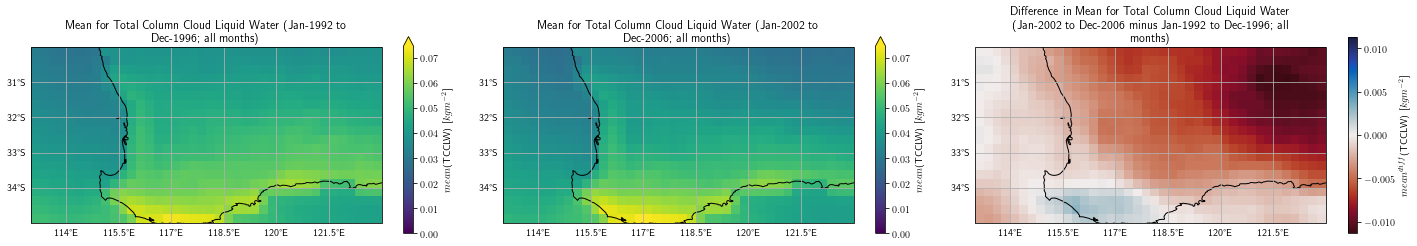

CPU times: user 3.66 s, sys: 603 ms, total: 4.26 s
Wall time: 3.48 s


In [19]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", var_or_dvar="tcclw", output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', None, 'wv100', None, None, None, None, None, None, None, None, True)_2022-09-27-23-18-02_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_wv100.nc.
CREATED: file for use in get_common_cbar_limits: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_wv100_st

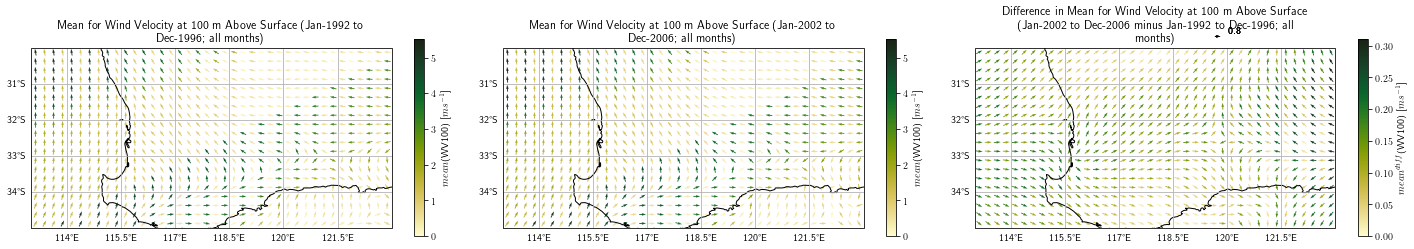

CPU times: user 4.94 s, sys: 986 ms, total: 5.93 s
Wall time: 4.71 s


In [20]:
%%time
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", var_or_dvar="wv100", output=True)

CREATED: log file for create_individual_calc_plot: ../logs/create_individual_calc_plot/create_individual_calc_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'all', 'mean', None, 'wv100', None, None, None, None, True)_2022-09-27-23-18-07_cfv1l.txt.
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc
CREATED: plot file: ../data_final/era5_mdp_clim_stats_given_var_or_dvar/pfv00_cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats_mean.png


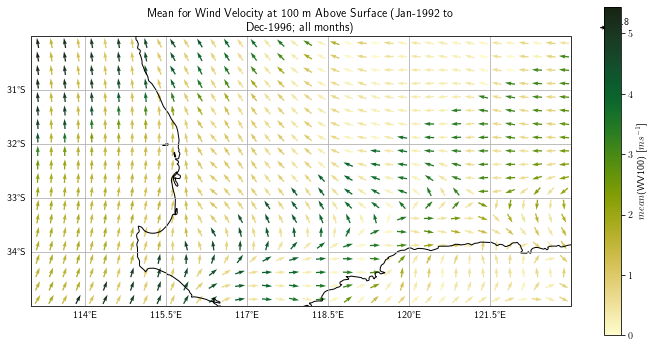

CPU times: user 458 ms, sys: 296 ms, total: 754 ms
Wall time: 376 ms


In [21]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "all", "mean", var_or_dvar="wv100", output=True)

CREATED: log file for create_individual_calc_plot: ../logs/create_individual_calc_plot/create_individual_calc_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'all', 'hour_min', None, 'wv10', None, None, None, None, True)_2022-09-27-23-18-07_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv10.nc.
CREATED: file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv10_stats.nc.
CREATED: plot file: ../data_final/era5_mdp_clim_stats_given_var_or_dvar/pfv00_cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv10_stats_hour_min.png


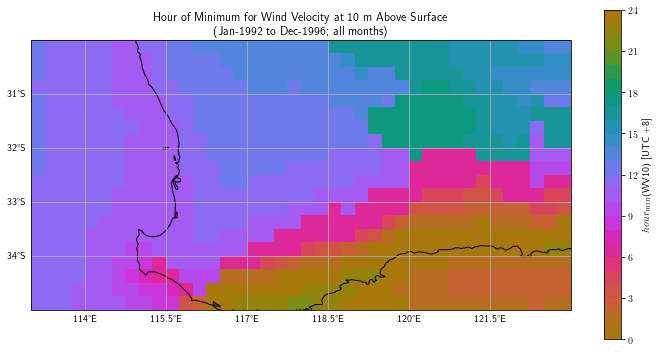

CPU times: user 1.64 s, sys: 365 ms, total: 2.01 s
Wall time: 1.54 s


In [22]:
%%time
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "all", "hour_min", var_or_dvar="wv10", output=True)

CREATED: log file for create_individual_diff_plot: ../logs/create_individual_diff_plot/create_individual_diff_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'hour_max', None, 'wv100', None, None, None, None, True)_2022-09-27-23-18-09_cfv1l.txt.
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
CREATED: plot file: ../data_final/era5_mdp_clim_stats_given_var_or_dvar/pfv00_cfv1l_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-

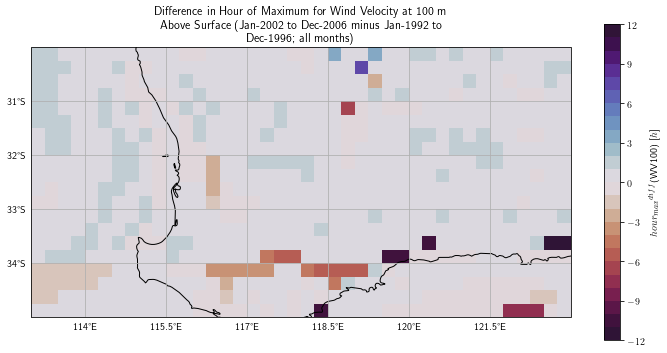

CPU times: user 629 ms, sys: 351 ms, total: 980 ms
Wall time: 543 ms


In [23]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "hour_max", var_or_dvar="wv100", output=True)

CREATED: log file for create_individual_diff_plot: ../logs/create_individual_diff_plot/create_individual_diff_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', [12, 1, 2], 'mean', None, 'ws100', None, None, None, None, True)_2022-09-27-23-18-09_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_1-2-12_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_1-2-12_era5-mdp_ws100_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_1-2-12_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_1-2-12_era5-mdp_ws100

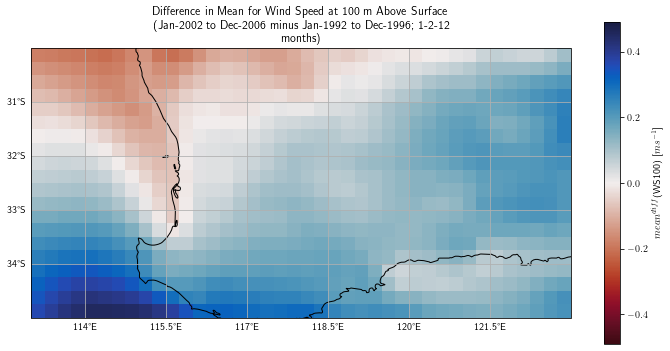

CPU times: user 2.15 s, sys: 300 ms, total: 2.45 s
Wall time: 2.04 s


In [24]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", [12, 1, 2], "mean", var_or_dvar="ws100", output=True)

CREATED: log file for create_individual_diff_plot: ../logs/create_individual_diff_plot/create_individual_diff_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'djf', 'mean', None, 'ws100', None, None, None, None, True)_2022-09-27-23-18-11_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_djf_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_djf_era5-mdp_ws100_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_djf_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_djf_era5-mdp_ws100_stats.nc.
Openin

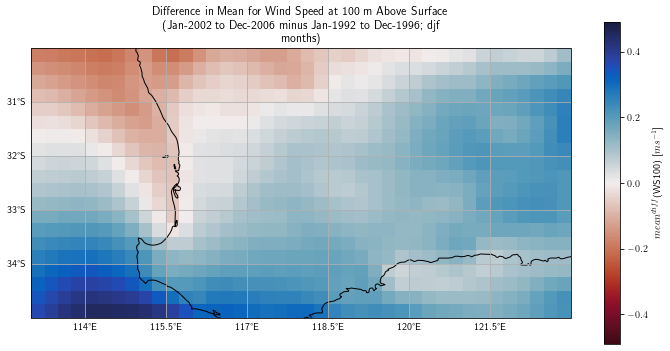

CPU times: user 2.13 s, sys: 313 ms, total: 2.44 s
Wall time: 2.02 s


In [25]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "djf", "mean", var_or_dvar="ws100", output=True)

CREATED: log file for create_individual_diff_plot: ../logs/create_individual_diff_plot/create_individual_diff_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'jja', 'mean', None, 'ws100', None, None, None, None, True)_2022-09-27-23-18-13_cfv1l.txt.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_jja_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-1992_Dec-1996_jja_era5-mdp_ws100_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/era5_mdp_clim_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_jja_era5-mdp_ws100.nc.
CREATED: file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1l_calc_wa_Jan-2002_Dec-2006_jja_era5-mdp_ws100_stats.nc.
Openin

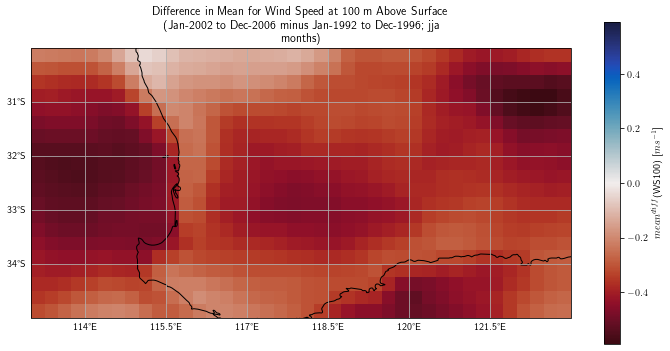

CPU times: user 2.23 s, sys: 372 ms, total: 2.6 s
Wall time: 2.11 s


In [26]:
%%time
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "jja", "mean", var_or_dvar="ws100", output=True)

In [ ]:
da_orog_eleva = xr.open_dataset(f"../data_processed/era5_orog_eleva/{cf.calc_funcs_ver}_calc_global_static_orog-eleva.nc")["lse"]
da_lai_mean = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc")["mlai"]
da_lai_mean_diff = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc")["mlai"]
da_mslp_mean = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_mslp_stats.nc")["mean"]
da_mslp_mean_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_mslp_stats.nc")["mean"]
da_mslp_hour_max = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_mslp_stats.nc")["hour_max"]
da_mslp_hour_max_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_mslp_stats.nc")["hour_max"]
da_ws100_mean = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_ws100_stats.nc")["mean"]
da_ws100_mean_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_ws100_stats.nc")["mean"]
da_wv100_mean_u = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc")["mean_u"]
da_wv100_mean_v = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc")["mean_v"]
da_wv100_mean_u_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")["mean_u"]
da_wv100_mean_v_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")["mean_v"]

In [ ]:
%%time
create_pcolormesh(da_orog_eleva, cf.regions["wa"]["extent"])

In [ ]:
%%time
create_pcolormesh(da_lai_mean)

In [ ]:
%%time
create_pcolormesh(da_lai_mean_diff)

In [ ]:
%%time
create_pcolormesh(da_mslp_mean)

In [ ]:
%%time
create_pcolormesh(da_mslp_mean_diff)

In [ ]:
%%time
create_pcolormesh(da_mslp_hour_max)

In [ ]:
%%time
create_pcolormesh(da_mslp_hour_max_diff)

In [ ]:
%%time
create_pcolormesh(da_ws100_mean)

In [ ]:
%%time
create_pcolormesh(da_ws100_mean_diff)

In [ ]:
%%time
create_quiver(da_wv100_mean_u, da_wv100_mean_v)

In [ ]:
%%time
create_quiver(da_wv100_mean_u_diff, da_wv100_mean_v_diff)

In [ ]:
# from dask.distributed import Client
# client = Client()
# client

In [ ]:
# client.close()

In [ ]:
import calc_funcs_v1j as cf
import ipywidgets as ipw
import hvplot.xarray # noqa
import hvplot.pandas # noqa
import panel as pn
import pandas as pd
import panel.widgets as pnw
import xarray as xr

In [ ]:
%%time
cf.calc_glass_mean_clim("wa", "Jun-2000", "Aug-2005", [8, 6,7])

In [ ]:
%%time
cf.calc_era5_mdp_clim_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "djf", "wv10")

In [ ]:
%%time
cf.calc_era5_mdp_clim_stats_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "jja", "dwv100")

In [ ]:
%%time
cf.calc_era5_wsd_clim("wa", "Jun-2000", "Aug-2005", [1,3,5,7,9,11])

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_given_var_or_dvar, "ca", "Jan-1985", "Dec-1994", "Jan-1995", "Jan-2004", "all", "dnac")

In [ ]:
test1 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_calc_wa_Jun-2000_Aug-2005_6-7-8_glass-mean_avhrr.nc")
test1

In [ ]:
test1["mlai"].plot()

In [ ]:
test1["mfapar"].plot()

In [ ]:
test2 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_calc_sa_Dec-1994_Feb-2000_djf_era5-mdp_wv10.nc")
test2

In [ ]:
test2["u10"].sel(hour=21).plot()

In [ ]:
test2["v10"].sel(hour=21).plot()

In [ ]:
test3 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_diff_ca_Jan-1985_Dec-1994_Jan-1995_Jan-2004_all_era5-mdp_dnac.nc")
test3

In [ ]:
test3["dnse"].sel(hour=21).plot()

In [ ]:
test3["dvidmf"].sel(hour=21).plot()

In [ ]:
test3["dvidcfwf"].sel(hour=21).plot()

In [ ]:
test3["dvidclwf"].sel(hour=21).plot()

In [ ]:
test3["dtcwv"].sel(hour=21).plot()

In [ ]:
test3["dnac"].sel(hour=21).plot()

In [ ]:
test4 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_dwv100_stats.nc")
test4

In [ ]:
test4["hour_max"].plot()

In [ ]:
test4["hour_min"].plot()

In [ ]:
test4["max_u"].plot()

In [ ]:
test4["max_v"].plot()

In [ ]:
test4["min_u"].plot()

In [ ]:
test4["min_v"].plot()

In [ ]:
test4["mean_u"].plot()

In [ ]:
test4["mean_v"].plot()

In [ ]:
test4["range"].plot()

In [ ]:
# test4["max"].plot()

In [ ]:
# test4["min"].plot()

In [ ]:
# test4["mean"].plot()

In [ ]:
test5 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_calc_wa_Jun-2000_Aug-2005_1-3-5-7-9-11_era5-wsd.nc")
test5

In [ ]:
test5["ws100_mean"].plot()

In [ ]:
test5["ws100_std"].plot()

In [ ]:
test5["c100"].plot()

In [ ]:
test5["k100"].plot()

In [ ]:
test5["eroe100"].plot()

In [ ]:
test5["tgcf100"].plot()

In [ ]:
test5["eroe100"].where(test5["eroe100"]==test5["eroe100"].max(), drop = True).squeeze()

In [ ]:
%%time
cf.calc_diff(cf.calc_glass_mean_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "nac")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "wv10")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_wsd_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

In [ ]:
test6 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_glass-mean_avhrr.nc")
test6

In [ ]:
test6["mlai"].plot()

In [ ]:
test6["mfapar"].plot()

In [ ]:
test7 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_nac.nc")
test7

In [ ]:
test7["nse"].sel(hour=21).plot()

In [ ]:
test7["vidmf"].sel(hour=21).plot()

In [ ]:
test7["vidcfwf"].sel(hour=21).plot()

In [ ]:
test7["vidclwf"].sel(hour=21).plot()

In [ ]:
test7["tcwv"].sel(hour=21).plot()

In [ ]:
test7["nac"].sel(hour=21).plot()

In [ ]:
test8 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_wv10_stats.nc")
test8

In [ ]:
test8["hour_max"].plot()

In [ ]:
test8["hour_min"].plot()

In [ ]:
test8["max_u"].plot()

In [ ]:
test8["max_v"].plot()

In [ ]:
test8["min_u"].plot()

In [ ]:
test8["min_v"].plot()

In [ ]:
test8["mean_u"].plot()

In [ ]:
test8["mean_v"].plot()

In [ ]:
test8["range"].plot()

In [ ]:
test9 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-wsd.nc")
test9

In [ ]:
test9["ws100_mean"].plot()

In [ ]:
test9["ws100_std"].plot()

In [ ]:
test9["c100"].plot()

In [ ]:
test9["k100"].plot()

In [ ]:
test9["eroe100"].plot()

In [ ]:
test9["tgcf100"].plot()

In [ ]:
test9["eroe100"].where(test9["eroe100"]==test9["eroe100"].max(), drop = True).squeeze()

In [ ]:
%%time
cf.calc_era5_orog_eleva()

In [ ]:
test10 = xr.open_dataset(f"../data_processed/era5_orog_eleva/{cf.calc_funcs_ver}_calc_global_static_orog-eleva.nc")
test10

In [ ]:
test10["lse"].plot()

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1984, 1987, 7)

In [ ]:
test11 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1984_1987_7-year_glass-rolling-diff_pref-avhrr.nc")
test11

In [ ]:
test11["mlai"].isel(year=0).plot()

In [ ]:
test11["mfapar"].isel(year=0).plot()

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1983, 2019, 5)

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1984, 2018, 7)

In [ ]:
test12 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1983_2019_5-year_glass-rolling-diff_pref-avhrr.nc")
test12

In [ ]:
test12["mlai"].interactive.sel(year=pnw.DiscreteSlider).plot(cmap = "RdBu", vmin = -1, vmax = 1)

In [ ]:
test13 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1984_2018_7-year_glass-rolling-diff_pref-avhrr.nc")
test13

In [ ]:
test13["mlai"].interactive.sel(year=pnw.DiscreteSlider).plot(cmap = "RdBu", vmin = -1, vmax = 1)

In [ ]:
%%time
cf.create_all_possible_calc_data_files("wa", "Jan-1992", "Dec-1996", "all")

In [ ]:
%%time
cf.create_all_possible_calc_data_files("wa", "Jan-2002", "Dec-2006", "all")

In [ ]:
%%time
cf.create_all_possible_diff_data_files("wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all")

In [ ]:
test14 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc")
test14["mlai"].plot()

In [ ]:
test15 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-wsd.nc")
test15["ws10_mean"].plot()

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "wv100")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "ws100")

In [ ]:
test16 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")
test16["range"].plot()

In [ ]:
test17 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_ws100_stats.nc")
test17["range"].plot()

In [ ]:
test16

In [ ]:
test17